### Patrick Horlaville (260931235) - Problem Set 5 - PHYS 512 : Computational Physics with Applications

Prof: Jon Sievers. TAs: Marcus Merryfield, Rigel Zifkin, Daniel Coelho

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import camb

Here I use the script from planck_likelihood.py in the mcmc directory, but it needs a slight adjustment for an arbitrary number of points for our spectrum:

In [65]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars, npts, lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2: npts + 2]

## Problem 1

First, we compute the CMB spectrum with the initial set of parameters from the test script, and we look at the resulting $\chi^2$

In [3]:
planck = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows = 1)
spectrum = planck[:,1]
errors = 0.5*(planck[:,2] + planck[:,3])
npts = len(spectrum)
npars = 6
N_inv = np.eye(npts)/(errors**2)

In [67]:
np.save("errors_CMB", errors)

In [7]:
pars_test = np.array([60, 0.02, 0.1, 0.05, 2.00e-9, 1.0])

In [46]:
pars_test = np.array([60, 0.02, 0.1, 0.05, 2.00e-9, 1.0])
model_test = get_spectrum(pars_test, npts)
residuals_test = spectrum - model_test
chisq_test = np.sum((residuals_test/errors)**2)
print("For the initial guess of parameters, χ2 =", chisq_test)

For the initial guess of parameters, χ2 = 15267.937968222595


In [45]:
pars_better = np.array([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
model_better = get_spectrum(pars_better, npts)
residuals_better = spectrum - model_better
chisq_better = np.sum((residuals_better/errors)**2)
print("With the more refined parameters, χ2 is now =", chisq_better)

With the more refined parameters, χ2 is now = 3272.2033778089576


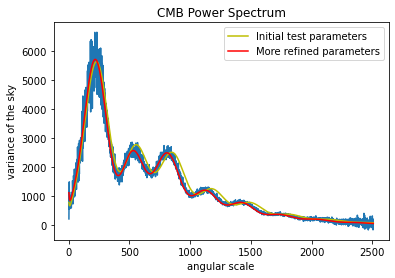

In [59]:
plt.plot(planck[:, 0], planck[:, 1])
plt.plot(planck[:, 0], model_test, 'y', label = 'Initial test parameters')
plt.plot(planck[:, 0], model_better, 'r', label = 'More refined parameters')
plt.xlabel('angular scale')
plt.ylabel('variance of the sky')
plt.title('CMB Power Spectrum')
plt.legend()

## Problem 2

Now we will use Levenberg-Marquardt to find the best-fit parameters of the cosmological model, using numerical derivatives. Firt we define the function to compute the numerical derivative. We take a step to be arbitrarily a 100th of each parameter's value, which should be of a reasonable order.

In [2]:
def get_deriv(pars):
    
    deriv_mat = np.empty([npts, npars])
    h = 0.01*pars
    
    for i in range(npars):
        
        deriv_mat[:, i] = (get_spectrum(pars + h, npts) - get_spectrum(pars - h, npts))/(2*h[i])
    
    return deriv_mat

A few other functions are defined prior to defining the LM fit function, which are taken from class notes. update_lamda adjusts the step size, get_matrices yields different matrix elements that are needed to the LM fit process (including the $\chi^2$ between the data and each model) and linv inverts required specified matrix elements.

In [3]:
def update_lamda(lamda, yes):
    if yes: 
        lamda = lamda/1.5
        if lamda < 0.5: 
            lamda = 0
    else: 
        if lamda == 0: 
            lamda = 1
        else:
            lamda = lamda*1.5**2
    return lamda

In [4]:
def get_matrices(pars, N_inv):
    
    model = get_spectrum(pars, npts)
    derivs = get_deriv(pars)
    
    res = spectrum - model
    
    lhs = derivs.T@N_inv@derivs
    rhs = derivs.T@N_inv@res
    chisq = res.T@N_inv@res
    
    return chisq, lhs, rhs

In [5]:
def linv(mat, lamda):
    mat = mat + lamda*np.diag(np.diag(mat))
    return np.linalg.inv(mat)

Now, we write the Levenberg-Marquardt fit. The covariance matrix is computed, which allows to compute the change in parameters. We compute the new $\chi^2$ and matrices elements from the updated parameters. If the $\chi^2$ decrease, from one step to another, is smaller than the threshold defined by chi_tol, the fit stops. If the number of steps are ran out, the fit stops. Otherwise, a new step is taken. If the $\chi^2$ increases, reject the step and take a new bigger one. 

In [6]:
def LM_fit(pars, N_inv, iterations, chi_tol = 0.01, pars_prior = None, pars_err = None):
    
    lamda = 0
    chisq, lhs, rhs = get_matrices(pars, N_inv)
    
    for i in range(iterations):
        if i == int(iterations/4):
            print('25%...')

        if i == int(iterations/2):
            print('50%...')
        
        if i == int(3*iterations/4):
            print('75%...')
        
        while True: 
            lhs_inv = linv(lhs, lamda)

            dpar = lhs_inv@rhs
            
            if (pars[3] + dpar[3] > 0.02) and (pars[3] + dpar[3] < 0.1):
                break
            else: 
                lamda = update_lamda(lamda, False)

        
        chisq_new, lhs_new, rhs_new = get_matrices(pars + dpar, N_inv)
        
        if pars_prior is not None:
            trial_prior = prior_chisq(pars + dpar, pars_prior, pars_err)
            chisq_new += trial_prior
        
        print('''
Iteration: {0}
Current χ2: {1}
Trial χ2: {2}
λ = {3}      
'''.format(i, chisq, chisq_new, lamda))
        
        if chisq_new < chisq:
            
            if lamda == 0.0:
                
                if (np.abs(chisq - chisq_new)<chi_tol):
                    print('Converged!')
                    return pars + dpar, lhs_new
            
            chisq = chisq_new
            lhs = lhs_new
            rhs = rhs_new
            pars += dpar
            lamda = update_lamda(lamda, True)
        
        else: 
            lamda = update_lamda(lamda, False)
        
    
    print('Max iterations achieved. Stopping program.')
    return pars, lhs

In [23]:
best_fit_pars, cov_inv = fit_lm(pars_test, N_inv, 10) 


Iteration: 0
Current χ2: 15267.937968222597
Trial χ2: 5105.982367185583
λ = 1      


Iteration: 1
Current χ2: 5105.982367185583
Trial χ2: 3487.886611905711
λ = 0.6666666666666666      

25%...

Iteration: 2
Current χ2: 3487.886611905711
Trial χ2: 3109.9263797721824
λ = 1      


Iteration: 3
Current χ2: 3109.9263797721824
Trial χ2: 2868.7378414619216
λ = 0.6666666666666666      


Iteration: 4
Current χ2: 2868.7378414619216
Trial χ2: 2776.618961809808
λ = 1      

50%...

Iteration: 5
Current χ2: 2776.618961809808
Trial χ2: 2696.8298811809664
λ = 0.6666666666666666      


Iteration: 6
Current χ2: 2696.8298811809664
Trial χ2: 2661.6934807816097
λ = 1      

75%...

Iteration: 7
Current χ2: 2661.6934807816097
Trial χ2: 2628.9814863010542
λ = 0.6666666666666666      


Iteration: 8
Current χ2: 2628.9814863010542
Trial χ2: 2614.268549601129
λ = 1      


Iteration: 9
Current χ2: 2614.268549601129
Trial χ2: 2600.422198794383
λ = 0.6666666666666666      

Max iterations achieved. Stopping

In [25]:
cov = np.linalg.inv(cov_inv)
err_params = np.sqrt(np.diag(cov))

H0, ombh2, omch2, tau, As, ns = best_fit_pars
err0, err1, err2, err3, err4, err5 = err_params
print('''
Best Fit Parameters:
--------------------

H0 = {0} ± {1}
Ωbh\u00b2 = {2} ± {3}
ΩCh\u00b2 = {4} ± {5}
τ = {6} ± {7}
As = {8} ± {9}
ns = {10} ± {11}

'''.format(H0, err0, ombh2, err1, omch2, err2, tau, err3, As, err4, ns, err5))

#Save curvature matrix for next problem.
np.savetxt('curvature_matrix_bestfit.txt', cov)

#Save best fit parameters and errors. 
np.savetxt('planck_fit_params.txt', np.vstack((best_fit_pars, err_params)))


Best Fit Parameters:
--------------------

H0 = 68.22939155168737 ± 1.1958948724330083
Ωbh² = 0.021685580112503978 ± 0.00022465727879873007
ΩCh² = 0.11534793493681698 ± 0.002631991377555628
τ = 0.04458364073985554 ± 0.039404447996244964
As = 2.0246662781923066e-09 ± 1.5316483998774847e-10
ns = 0.9819095032925432 ± 0.006385269293459393




## Problem 3

Now, we will perform a similar task to find more refined cosmological parameters, but using a Monte-Carlo Markov Chain (MCMC). To do so, we first generate a random step from our curvature matrix found before. We find the corresponding parameters' evolution, which yields a new $\chi^2$. The step is accepted on a stochastic basis. Then, the process repeats itself, with the updated (or not) parameters.

In [26]:
# The goal of this question is to get an MCMC working, using prior knowledge of the stepsize. 
# Let's start by defining a few fundamental functions. 

# Get χ2 for a set of parameters with noise
def get_chisq(pars, noise = errors):
    
    model = get_spectrum(pars, npts)
    r = spectrum - model
    chisq = np.sum((r/noise)**2)
    
    return chisq

# Cholesky decomposition
def cholesky_decomp(mat):
    return np.linalg.cholesky(mat)


# Main MCMC function
def MCMC(pars, curv_mat, nstep, noise = errors, pars_prior = None, pars_err = None):
    
    # Get starting χ2 value
    chi_cur = get_chisq(pars, noise)
    
    # Initialize chain and χ2 vector
    chain = np.zeros([nstep, npars])
    chi_vec = np.zeros(nstep)
    
    # Track how many trials get accepted. Expect 25%.
    accepted_counter = 0
    
    # Get cholesky decomposition
    cholesky_mat = cholesky_decomp(curv_mat)
    
    # Begin chain
    for i in range(nstep):
        
        if i == int(nstep/4):
            print('25% Complete.')

        if i == int(nstep/2):
            print('50% Complete.')
        
        if i == int(3*nstep/4):
            print('75% Complete.')
            
        # Make sure that τ stays as a reasonable value
        while True: 
            
            # Generate random step using cholesky decomp
            dpar = cholesky_mat@np.random.randn(npars)

            # Check to see if τ becomes unphysical. If yes, try another step.
            if (pars[3] + dpar[3] > 0.02) and (pars[3] + dpar[3] < 0.1):
                break
        
        # Update parameters
        trial_pars = pars + dpar
        trial_chisq = get_chisq(trial_pars, noise)
        
        # Condition to update χ2 if prior is given (For problem 4)
        if pars_prior is not None: 
            trial_chisq += prior_chisq(trial_pars, pars_prior, pars_err)
            
        # Compute change in χ2
        dchisq = trial_chisq - chi_cur
        
        # Get probability of accepting
        prob_accept = np.exp(-0.5*dchisq)
        accept = np.random.rand(1) < prob_accept
        
        # If accepted, set new parameters and move on to step.
        if accept: 
            accepted_counter +=1
            pars = trial_pars
            chi_cur = trial_chisq
            
        
        chain[i,:] = pars
        chi_vec[i] = chi_cur
        
    print('Out of {0} steps, {1} were accepted ({2}%).'.format(nstep, accepted_counter, 100*accepted_counter/nstep))
    
    return chain, chi_vec 

In [63]:
# Set starting parameters and load in best fit curvature matrix from Question 2. 
pars_start = np.asarray([60, 0.02, 0.1, 0.05, 2.00e-9, 1.0])
cov = np.loadtxt('curvature_matrix_bestfit.txt')

# Run MCMC
chain, chisq = MCMC(pars_start, cov, 10)

# Save data
data = np.empty((len(chisq), npars + 1))
data[:,0] = chisq
for i in range(npars):
    data[:, i + 1] = chain[:, i]

25% Complete.
50% Complete.
75% Complete.
Out of 10 steps, 5 were accepted (50.0%).


In [30]:
np.savetxt('planck_chain.txt', data)

In [31]:
data = np.loadtxt('planck_chain.txt').T
chisq = data[0,:]
H0 = data[1, :]
omega_bh2 = data[2, :]
omega_ch2 = data[3,: ]
τ = data[4,: ]
A_s = data[5,: ]
n_s = data[6, :]

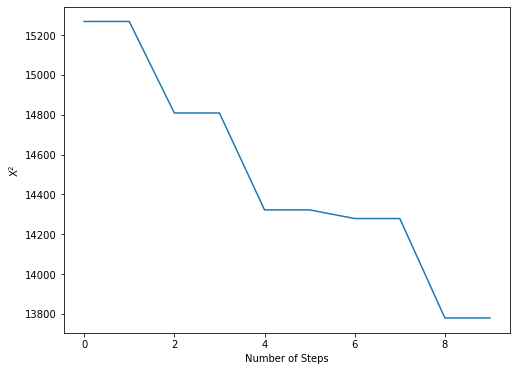

In [32]:
plt.figure(figsize = (8,6))
plt.plot(chisq)
plt.xlabel('Number of Steps')
plt.ylabel('Χ$^2$')
plt.savefig('chi2_full')
plt.show()

Given the decrease and stabilization of the $\chi^2$, it is fair to assume that our MCMC chain has yielded a chain that converged. If the $\chi^2$ kept decreasing, or increasing, or varying non-sensically, then that would be another story.

In [35]:
# Let's now determine the best fit parameters by taking the mean after the burn in period
best_fit_pars = np.mean(data[1::], axis = 1)
err_params = np.std(data[1::], axis = 1)

H0, ombh2, omch2, tau, As, ns = best_fit_pars
err0, err1, err2, err3, err4, err5 = err_params
print('''
Best Fit Parameters:
--------------------

H0 = {0} ± {1}
Ωbh\u00b2 = {2} ± {3}
ΩCh\u00b2 = {4} ± {5}
τ = {6} ± {7}
As = {8} ± {9}
ns = {10} ± {11}

'''.format(H0, err0, ombh2, err1, omch2, err2, tau, err3, As, err4, ns, err5))


Best Fit Parameters:
--------------------

H0 = 59.309732995996946 ± 0.3933717607888796
Ωbh² = 0.02010328008368875 ± 0.0002060410809710396
ΩCh² = 0.10236776686231078 ± 0.0015896113668523722
τ = 0.07281894297446592 ± 0.023035235928510433
As = 2.102427608095415e-09 ± 9.968756946162028e-11
ns = 0.9958590849694955 ± 0.0038103595432840746




We also want an estimate on $\Omega_\lambda$, which is, as cued by the problem statement, given by $1 - (\frac{100}{H_0}^2) \cdot (\Omega_b h^2 + \Omega_C h^2)$, from which we can also derive its error:

In [36]:
# Estimate Ω_Λ
h = H0/100
omega_lamda = 1 - (ombh2 + omch2)/(h**2)
err_omlam = omega_lamda*((ombh2/err1)**-2 + (omch2/err2)**-2 + 8*(err0/H0)**2)**(1/2)
print('''
Ωλ = {0} \pm {1}
'''.format(omega_lamda, err_omlam))


Ωλ = 0.6518379004734522 \pm 0.01722255562550944



## Problem 4

In [37]:
# To begin this question, we need to re-estimate the covariance matrix using importance sampling. In both
# fit_lm and MCMC, I've included two parameters, par_priors and par_errs. If we add in these parameters,
# an updated χ2 will be calculated to take into account these priors using the below function:

def prior_chisq(pars, pars_prior, pars_err):
    par_shifts = pars - pars_prior 
    return np.sum((par_shifts/pars_err)**2)

In [38]:
# Set priors
pars_prior = np.array([0.0,0.0,0.0, 0.0540, 0.0, 0.0])
pars_err = np.zeros(npars) + 1e20
pars_err[3] = 0.0074

# Initial guess
pars_start = np.asarray([60, 0.02, 0.1, 0.05, 2.00e-9, 1.0])

# Get updated parameter covariance matrix
best_fit_pars, cov_inv = fit_lm(pars_start, N_inv, 10, pars_prior = pars_prior, pars_err = pars_err)

#Save updated curvature matrix for next problem.
np.savetxt('curvature_matrix_bestfit_tauprior.txt', np.linalg.inv(cov_inv))


Iteration: 0
Current χ2: 15267.937968222597
Trial χ2: 5106.029934586267
λ = 1      


Iteration: 1
Current χ2: 5106.029934586267
Trial χ2: 3487.9086594841
λ = 0.6666666666666666      

25%...

Iteration: 2
Current χ2: 3487.9086594841
Trial χ2: 3110.10271976222
λ = 1      


Iteration: 3
Current χ2: 3110.10271976222
Trial χ2: 2869.2102226175493
λ = 0.6666666666666666      


Iteration: 4
Current χ2: 2869.2102226175493
Trial χ2: 2777.298683863679
λ = 1      

50%...

Iteration: 5
Current χ2: 2777.298683863679
Trial χ2: 2697.7719376485134
λ = 0.6666666666666666      


Iteration: 6
Current χ2: 2697.7719376485134
Trial χ2: 2662.80355759297
λ = 1      

75%...

Iteration: 7
Current χ2: 2662.80355759297
Trial χ2: 2630.304187516036
λ = 0.6666666666666666      


Iteration: 8
Current χ2: 2630.304187516036
Trial χ2: 2615.7236549628315
λ = 1      


Iteration: 9
Current χ2: 2615.7236549628315
Trial χ2: 2602.0414066416456
λ = 0.6666666666666666      

Max iterations achieved. Stopping program.


In [39]:
cov_tauprior = np.loadtxt('curvature_matrix_bestfit_tauprior.txt')

chains_prior, chisq_prior = MCMC(pars_start, cov_tauprior, 10, pars_prior = pars_prior, pars_err = pars_err)

# Save data
data = np.empty((len(chisq_prior), npars + 1))
data[:,0] = chisq_prior
for i in range(npars):
    data[:, i + 1] = chains_prior[:, i]

np.savetxt('planck_chain_tauprior.txt', data)

25% Complete.
50% Complete.
75% Complete.
Out of 10 steps, 1 were accepted (10.0%).


In [40]:
# Read in data for plotting purposes
data = np.loadtxt('planck_chain_tauprior.txt').T
chisq = data[0,:]
H0 = data[1, :]
omega_bh2 = data[2, :]
omega_ch2 = data[3,: ]
τ = data[4,: ]
A_s = data[5,: ]
n_s = data[6, :]

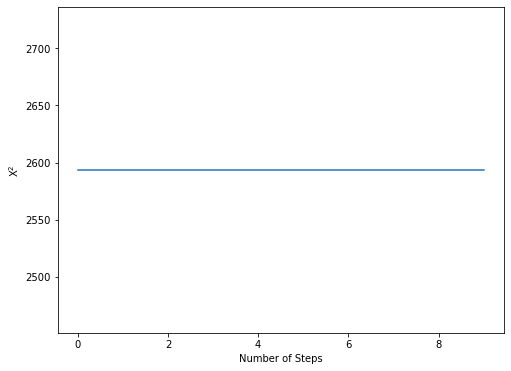

In [41]:
# Plot χ2
plt.figure(figsize = (8,6))
plt.plot(chisq)
plt.xlabel('Number of Steps')
plt.ylabel('Χ$^2$')
plt.savefig('chi2_full_tauprior')
plt.show()